# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [69]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [70]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**b.** Use the cell below to find the number of rows in the dataset.

In [72]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [73]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [74]:
df.converted.mean() * 100

11.965919355605511

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [75]:
df.query('group == "treatment" and landing_page == "old_page"').shape[0] + df.query('group == "control" and landing_page == "new_page"').shape[0]

3893

**f.** Do any of the rows have missing values?

In [76]:
print(df.isnull().sum().sum())
print(df.isna().sum().sum())

0
0


In [77]:
# Calculate the duration of the experiment
# A copy of the DataFrame
df_copy = df
df_copy['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df_copy['timestamp'].max() - df_copy['timestamp'].min() 

Timedelta('21 days 23:59:49.081927')

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [78]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df_t = df.query('group == "control" and landing_page == "new_page"').index
df_n = df.query('group == "treatment" and landing_page == "old_page"').index
df_all = df_t.append(df_n)
df2 = df.drop(df_all, axis=0)

In [79]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [80]:
df.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [81]:
df2[df2.duplicated(['user_id'], keep='first')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927+00:00,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [82]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806+00:00,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927+00:00,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [83]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because 
# the rows with duplicate user_id are not entirely identical. 
df2.drop(index=2893, axis=0, inplace=True)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [84]:
converted = df2.converted.mean()
print(f"the probability of an individual converting: {converted}")

the probability of an individual converting: 0.11959708724499628


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [85]:

control_conv = df2[df2['group'] == "control"]['converted'].mean()
print(f"the probability that an individual in the control group was converted: {control_conv}")

the probability that an individual in the control group was converted: 0.1203863045004612


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [86]:
treatment_conv = df2[df2['group'] == "treatment"]['converted'].mean()
print(f"the probability that an individual in the treatment group was converted: {treatment_conv}")

the probability that an individual in the treatment group was converted: 0.11880806551510564


In [87]:
# Calculate the actual difference (obs_diff) between the conversion rates of the two groups.
obs_diff = treatment_conv - control_conv
print(f"the actual difference between the conversion rates for the two groups: {obs_diff}")

the actual difference between the conversion rates for the two groups: -0.0015782389853555567


**d.** What is the probability that an individual received the new page?

In [88]:
new_page = (df2.landing_page == 'new_page').mean()
print(f"the probability that an individual received the new page: {new_page}")

the probability that an individual received the new page: 0.5000619442226688


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**As per the findings above, the treatment group has produced a lower conversion rate of 0.00158. Therefore, the difference between the converted rate generated from the control and treatment indicates that the new page will not help raise the conversion rate.**

>**Nonetheless, further analysis is required in order to have a better understanding of the data.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

**The mean difference between the old page and the new page conversion rates is positive and close to 0. Thus, it would be best to construct our alternative by expecting the coversion rate of the new page to be higher than the old page's rate.**

$$H_0: p_{new} - p_{old} ≤ 0$$


$$H_1: p_{new} - p_{old} > 0$$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [89]:
p_new = df2['converted'].mean()
print(f"the conversion rate for 𝑝_𝑛𝑒𝑤 under the null hypothesis: {p_new}")

the conversion rate for 𝑝_𝑛𝑒𝑤 under the null hypothesis: 0.11959708724499628


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [90]:
p_old = p_new
print(f"the conversion rate for 𝑝_𝑜𝑙𝑑 under the null hypothesis: {p_old}")

the conversion rate for 𝑝_𝑜𝑙𝑑 under the null hypothesis: 0.11959708724499628


**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [91]:
n_new = df2.query('group == "treatment"')['converted'].shape[0]
print(f"the number of individuals in the treatment group: {n_new}")

the number of individuals in the treatment group: 145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [92]:
n_old = df2.query('group == "control"')['converted'].shape[0]
print(f"the number of individuals in the control group: {n_old}")

the number of individuals in the control group: 145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [93]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2, n_new, p = [1-p_old,p_old])
print(f"Simulate a Sample for the treatment Group: {new_page_converted}")

Simulate a Sample for the treatment Group: [0 1 0 ..., 0 0 0]


**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [94]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2, n_old, p=[1-p_old,p_old])
print(f"Simulate a Sample for the control Group: {old_page_converted}")

Simulate a Sample for the control Group: [0 0 0 ..., 0 0 1]


**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [95]:
diff_conv = new_page_converted.mean() - old_page_converted.mean()
diff_conv

-0.00063545605733306143


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [96]:
# Sampling distribution 
p_diffs = []

# Bootsample the df2 using the same number of individuals in each of the two groups
for _ in range(10000):
    new_page_converted = np.random.choice(2, n_new, p = [1-p_old,p_old])
    old_page_converted = np.random.choice(2, n_old, p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

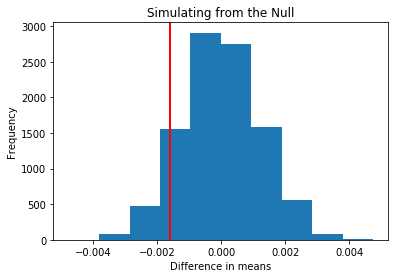

In [97]:
plt.hist(p_diffs)
plt.axvline(obs_diff,color='r', linewidth=2)
plt.title("Simulating from the Null")
plt.xlabel("Difference in means")
plt.ylabel("Frequency");

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [98]:
print(f"proportion of the p_diffs greater than the actual difference observed in the df2 data: {(p_diffs > obs_diff).mean()}")

proportion of the p_diffs greater than the actual difference observed in the df2 data: 0.9025


**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**The p-value of the probability of observing the statistic is greater than observed differences by 90%.**

>**Since the p-value is the probability of getting our statistic or a more extreme value if the null is true, the large p-value suggests that we have enough evidence that our statistic was likely to come from the null hypothesis. With a p-value larger than the type I error rate of 5% we do not have evidence to reject the null.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [99]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
print(f"number of conversions with the old_page: {convert_old}")
# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
print(f"number of conversions with the new_page: {convert_new}")
# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]
print(f"number of individuals who were shown the old_page: {n_old}")
# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]
print(f"number of individuals who received new_page: {n_new}")

number of conversions with the old_page: 17489
number of conversions with the new_page: 17264
number of individuals who were shown the old_page: 145274
number of individuals who received new_page: 145310


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

In [100]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger') # the alternative is 'larger since the p_diffs > obs_diff'
print(f" the Z_score is : {z_score}, whislt the p_value is {p_value}")

 the Z_score is : -1.3109241984234394, whislt the p_value is 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**We have a right-tailed alternative hypothesis that places the "rejection zone" in the area of the Z_score > Z_0.05 expression. In our case, the Z_score is -1.31 whilst the Z_0.01 is 1.645 for a 95% confidence interval. Hence the rejection region falls between [1.645,∞).**

>**This being said, the test statistic does not fall in the rejection region, because Z_score is smaller than the alpha value. Therefore, we do not have enough evidence to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Having in mind that each row in the df2 is either a conversion or no conversion, thus binary and constrained, we will be performing a logistic regression. The predicted response variable will be therefore limited to a probability between 0 and 1.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

df2[['no_ab_page','ab_page']] = pd.get_dummies(df['group'])
df2 = df2.drop('no_ab_page', axis=1)
df2['intercept'] = 1

In [102]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739+00:00,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739+00:00,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213+00:00,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765+00:00,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827+00:00,control,old_page,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [103]:
# Instantiate logistic regression model
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])

# Fit the model
results = logit_mod.fit()

# Get summary statistics
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-09 14:58 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [104]:
# Calculate the reciprocal of the convertion.
1/(np.exp(-0.0150))

1.0151130646157189

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

>**The p-value associated with the ab_page calculated by sm.Logit function is 0.1899. This value is different from the p-value obtained in Part II, which is 0.90 both by using the z-test and sampling distribution by bootstrapping.**

>**The difference between the hypothesis in Part II and Part III is the scope of the method employed. The Part II hypothesis directed the research towards an understanding of which of the two pages produced a higher convergence rate. The Part III hypothesis was used to classify our data to better understand the likelihood of observing a particular rate of convergence based on a particular page.** 

>**Also, the p-value has been influenced by the fact that the logistic regression model is not limiting the equation to a specific range as we saw with the Z_test.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Since we have only included a single factor to observe the likelihood of a particular determinant value of the convergence rate on a particular page, it would be great to further explore the data by adding an additional factor.**

>**For logistic regression, it is recommended to have two or more x values or predictors. However, we need to be aware that if we add too many variables to the model we might experience what is called a model overfit. Another thing to keep in mind is to avoid fitting highly related variables, such as the landing page and groups.** 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [105]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [106]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, countries, on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739+00:00,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739+00:00,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213+00:00,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765+00:00,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827+00:00,control,old_page,1,0,1,US


In [107]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739+00:00,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739+00:00,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213+00:00,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765+00:00,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827+00:00,control,old_page,1,0,1,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [108]:
## Fit your model, and summarize the results

# Add an intercept columns
df_merged['intercept'] = 1

# Add the columns of the interaction between page and country
df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']

# Instantiate logistic regression model
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

# Fit the model
results = logit_mod.fit()

# Get summary statistics
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-06-09 14:58 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

In [109]:
# Exponentiate each relevant result and explain it
print(f"• for every 1 unit decrease in convertion rate, the new page is {1/np.exp(-0.0206)} times as likely to account for that convertion; \n• for every 1 unit increase in convertion rate, the UK is {1/np.exp(0.0314)} times as likely to account for that convertion;, \n• for every 1 unit decrease in convertion rate, the CA is {np.exp(-0.0469)} times as likely to account for that convertion.")
print("\n")
print(f"Also, the following numbers are only related to the size of each country: \n- for every 1 row increase of US data there will be a smaller overall proportion of UK rows by {np.exp(-0.0057)} and CA {np.exp(-0.0175)}.")

• for every 1 unit decrease in convertion rate, the new page is 1.020813644503746 times as likely to account for that convertion; 
• for every 1 unit increase in convertion rate, the UK is 0.9690878603945013 times as likely to account for that convertion;, 
• for every 1 unit decrease in convertion rate, the CA is 0.9541828111007262 times as likely to account for that convertion.


Also, the following numbers are only related to the size of each country: 
- for every 1 row increase of US data there will be a smaller overall proportion of UK rows by 0.9943162141784332 and CA 0.9826522356650732.


>**In this analysis we have used several methods in order to gather proof that our preliminary observation to not change the current page to the new one is worth pursuing. Therefore, we have used the hypothesis testing by finding the p-value via sampling distribution of the mean difference, Z_test and logistic regression.**

>**Also, we have included an additional variable to the logistic regression model i.e. three countries namely Canada, the United Kingdom and the United States.**

>**This being said, we can say with 95% confidence that we do not have enough proofs to reject the null hypothesis where the old page is providing the same rate of convergence.**

>**Also, we can add that the convergence rate for the UK is the highest among the three, with CA having the lowest amongst them.**

>**At this point, we can emphasise two types of practical significance of this analysis. First is that the data suggest that one variable has a positive coefficient value that would indicate actions toward that particular area. For example, we saw that the UK provides the highest convergence rate for the new page. However, the overall convergence rate of the new page reduces its practical significance. Nonetheless, the second type of practical significance is extracted from the fact that the convergence rate of the new page is low enough to make improvements or to give up this project. Also, since the UK had the highest convergence rate among the three countries, we can develop a new investigative project to better understand the reason behind this rate. Chances are we could dive deeper into what makes a page work better in the UK and therefore, extrapolate the idea that each country has its particularities that could be used for a new project.**

In [110]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0